In [89]:
import matplotlib
from matplotlib.axes import Axes
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.ticker import NullLocator, Formatter, FixedLocator
from matplotlib.transforms import Affine2D, BboxTransformTo, IdentityTransform
from matplotlib.projections import register_projection
import matplotlib.spines as mspines
import matplotlib.axis as maxis
import matplotlib.pyplot as plt

import numpy as np

class TriangularAxes(Axes):
    """
    A custom class for triangular projections.
    """

    name = 'triangular'

    def __init__(self, *args, **kwargs):
        Axes.__init__(self, *args, **kwargs)
        self.set_aspect(1, adjustable='box', anchor='SW')
        self.cla()

    def _init_axis(self):
        self.xaxis = maxis.XAxis(self)
        self.yaxis = maxis.YAxis(self)
        self._update_transScale()

    def cla(self):
        """
        Override to set up some reasonable defaults.
        """
        # Don't forget to call the base class
        Axes.cla(self)
        
        x_min = 0
        y_min = 0
        x_max = 1
        y_max = 1
        x_spacing = 0.1
        y_spacing = 0.1
        self.xaxis.set_minor_locator(NullLocator())
        self.yaxis.set_minor_locator(NullLocator())
        self.xaxis.set_ticks_position('bottom')
        self.yaxis.set_ticks_position('left')
        Axes.set_xlim(self, x_min, x_max)
        Axes.set_ylim(self, y_min, y_max)
        self.xaxis.set_ticks(np.arange(x_min, x_max+x_spacing, x_spacing))
        self.yaxis.set_ticks(np.arange(y_min, y_max+y_spacing, y_spacing))

    def _set_lim_and_transforms(self):
        """
        This is called once when the plot is created to set up all the
        transforms for the data, text and grids.
        """
        # There are three important coordinate spaces going on here:
        #
        #    1. Data space: The space of the data itself
        #
        #    2. Axes space: The unit rectangle (0, 0) to (1, 1)
        #       covering the entire plot area.
        #
        #    3. Display space: The coordinates of the resulting image,
        #       often in pixels or dpi/inch.

        # This function makes heavy use of the Transform classes in
        # ``lib/matplotlib/transforms.py.`` For more information, see
        # the inline documentation there.

        # The goal of the first two transformations is to get from the
        # data space (in this case longitude and latitude) to axes
        # space.  It is separated into a non-affine and affine part so
        # that the non-affine part does not have to be recomputed when
        # a simple affine change to the figure has been made (such as
        # resizing the window or changing the dpi).

        # 1) The core transformation from data space into
        # rectilinear space defined in the HammerTransform class.
        self.transProjection = IdentityTransform()
        # 2) The above has an output range that is not in the unit
        # rectangle, so scale and translate it so it fits correctly
        # within the axes.  The peculiar calculations of xscale and
        # yscale are specific to a Aitoff-Hammer projection, so don't
        # worry about them too much.
        self.transAffine = Affine2D.from_values(
                1., 0, 0.5, np.sqrt(3)/2., 0, 0)
        self.transAffinedep = Affine2D.from_values(
                1., 0, -0.5, np.sqrt(3)/2., 0, 0)
        #self.transAffine = IdentityTransform()
        
        # 3) This is the transformation from axes space to display
        # space.
        self.transAxes = BboxTransformTo(self.bbox)

        # Now put these 3 transforms together -- from data all the way
        # to display coordinates.  Using the '+' operator, these
        # transforms will be applied "in order".  The transforms are
        # automatically simplified, if possible, by the underlying
        # transformation framework.
        self.transData = \
            self.transProjection + \
            self.transAffine + \
            self.transAxes

        # The main data transformation is set up.  Now deal with
        # gridlines and tick labels.

        # Longitude gridlines and ticklabels.  The input to these
        # transforms are in display space in x and axes space in y.
        # Therefore, the input values will be in range (-xmin, 0),
        # (xmax, 1).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the equator.

        self._xaxis_pretransform = IdentityTransform()
        self._xaxis_transform = \
            self._xaxis_pretransform + \
            self.transData
        self._xaxis_text1_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, -20.0)
        self._xaxis_text2_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, -4.0)

        # Now set up the transforms for the latitude ticks.  The input to
        # these transforms are in axes space in x and display space in
        # y.  Therefore, the input values will be in range (0, -ymin),
        # (1, ymax).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the edge of the axes ellipse.

        self._yaxis_transform = self.transData
        yaxis_text_base = \
            self.transProjection + \
            (self.transAffine + \
             self.transAxes)
        self._yaxis_text1_transform = \
            yaxis_text_base + \
            Affine2D().translate(-8.0, 0.0)
        self._yaxis_text2_transform = \
            yaxis_text_base + \
            Affine2D().translate(8.0, 0.0)

    def get_xaxis_transform(self,which='grid'):
        assert which in ['tick1','tick2','grid']
        return self._xaxis_transform

    def get_xaxis_text1_transform(self, pad):
        return self._xaxis_text1_transform, 'bottom', 'center'

    def get_xaxis_text2_transform(self, pad):
        return self._xaxis_text2_transform, 'top', 'center'

    def get_yaxis_transform(self,which='grid'):
        assert which in ['tick1','tick2','grid']
        return self._yaxis_transform

    def get_yaxis_text1_transform(self, pad):
        return self._yaxis_text1_transform, 'center', 'right'

    def get_yaxis_text2_transform(self, pad):
        return self._yaxis_text2_transform, 'center', 'left'

    def _gen_axes_spines(self):
        dep_spine = mspines.Spine.linear_spine(self,
                                                   'right')
        # Fix dependent axis to be transformed the correct way
        dep_spine.set_transform(self.transAffinedep + self.transAxes)
        return {'left':mspines.Spine.linear_spine(self,
                                                   'left'),
                'bottom':mspines.Spine.linear_spine(self,
                                                   'bottom'),
		'right':dep_spine}

    def _gen_axes_patch(self):
        """
        Override this method to define the shape that is used for the
        background of the plot.  It should be a subclass of Patch.
        Any data and gridlines will be clipped to this shape.
        """

        return Polygon([[0,0], [0.5,np.sqrt(3)/2], [1,0]], closed=True)

    # Interactive panning and zooming is not supported with this projection,
    # so we override all of the following methods to disable it.
    def can_zoom(self):
        """
        Return True if this axes support the zoom box
        """
        return False
    def start_pan(self, x, y, button):
        pass
    def end_pan(self):
        pass
    def drag_pan(self, button, key, x, y):
        pass


# Now register the projection with matplotlib so the user can select
# it.
register_projection(TriangularAxes)

In [90]:
import pycalphad.io.tdb_keywords
pycalphad.io.tdb_keywords.TDB_PARAM_TYPES.extend(['EM', 'BULK', 'SHEAR', 'C11', 'C12', 'C44'])
from pycalphad import Database, Model, calculate, equilibrium
import numpy as np
import pycalphad.variables as v
import sympy
from tinydb import where

class ElasticModel(Model):
    def build_phase(self, dbe, phase_name, symbols, param_search):
        phase = dbe.phases[phase_name]
        self.models['ref'] = self.reference_energy(phase, param_search)
        self.models['idmix'] = self.ideal_mixing_energy(phase, param_search)
        self.models['xsmix'] = self.excess_mixing_energy(phase, param_search)
        self.models['mag'] = self.magnetic_energy(phase, param_search)

        # Here is where we add our custom contribution
        # EM, BULK, SHEAR, C11, C12, C44
        for prop in ['EM', 'BULK', 'SHEAR', 'C11', 'C12', 'C44']:
            prop_param_query = (
            (where('phase_name') == phase.name) & \
            (where('parameter_type') == prop) & \
            (where('constituent_array').test(self._array_validity))
            )
            prop_val = self.redlich_kister_sum(phase, param_search, prop_param_query)
            setattr(self, prop, prop_val)

        # Extra code necessary for compatibility with order-disorder model
        ordered_phase_name = None
        disordered_phase_name = None
        try:
            ordered_phase_name = phase.model_hints['ordered_phase']
            disordered_phase_name = phase.model_hints['disordered_phase']
        except KeyError:
            pass
        if ordered_phase_name == phase_name:
            self.models['ord'] = self.atomic_ordering_energy(dbe,
                                                             disordered_phase_name,
                                                             ordered_phase_name)

In [91]:
dbf = Database('ElasticTi.tdb')
mod = ElasticModel(dbf, ['TI', 'MO', 'NB', 'VA'], 'BCC_A2')
symbols = dict([(sympy.Symbol(s), val) for s, val in dbf.symbols.items()])
mod.EM = mod.EM.xreplace(symbols)
x1 = np.linspace(0,1, num=100)
x2 = np.linspace(0,1, num=100)
mesh = np.meshgrid(x1, x2)
X = mesh[0]
Y = mesh[1]
mesh_arr = np.array(mesh)
mesh_arr = np.moveaxis(mesh_arr, 0, 2)
dep_col = 1 - np.sum(mesh_arr, axis=-1, keepdims=True)
mesh_arr = np.concatenate((mesh_arr, dep_col), axis=-1)
mesh_arr = np.concatenate((mesh_arr, np.ones(mesh_arr.shape[:-1] + (1,))), axis=-1)
orig_shape = tuple(mesh_arr.shape[:-1])
mesh_arr = mesh_arr.reshape(-1, mesh_arr.shape[-1])
mesh_arr[np.any(mesh_arr < 0, axis=-1), :] = np.nan
res = calculate(dbf, ['TI', 'MO', 'NB', 'VA'], 'BCC_A2', T=300, P=101325,
                model=mod, output='EM', points=mesh_arr)
res_EM = res.EM.values.reshape(orig_shape)

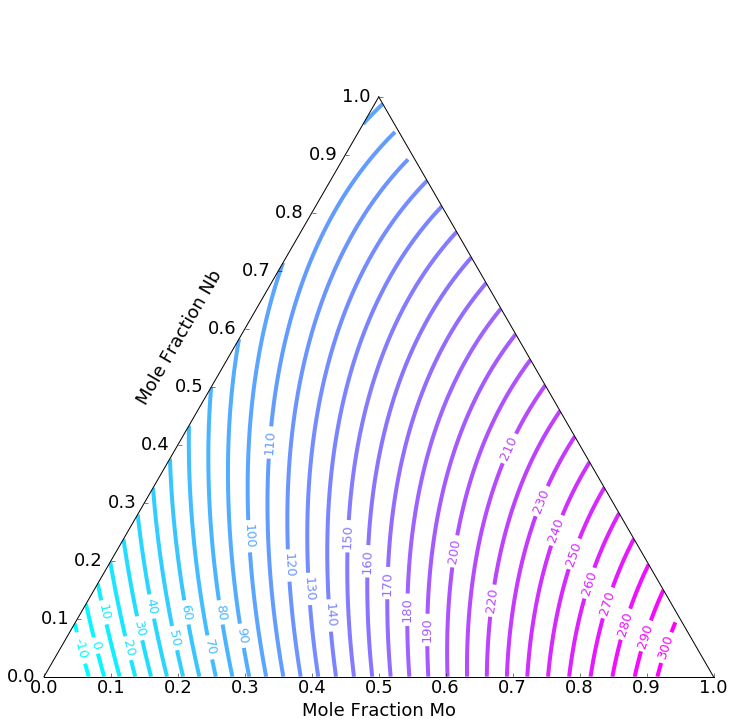

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='triangular')
CS = ax.contour(X, Y, res_EM, levels=list(range(-10, 310, 10)), linewidths=4, cmap='cool')
ax.clabel(CS, inline=1, fontsize=13, fmt='%1.0f')
#PCM=ax.get_children()[0] #get the mappable, the 1st and the 2nd are the x and y axes
#plt.colorbar(PCM, ax=ax)
ax.set_xlabel('Mole Fraction Mo', fontsize=18)
ax.set_ylabel('Mole Fraction Nb', fontsize=18, rotation=60, labelpad=-180)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
fig.savefig('TiMoNb-EM.pdf')